# Arrival Time Prediction - Synchronisation
This notebook is the third on the work on GP regression for arrival time prediction. The goal of this one is to estimate a function for each segment that synchonises the progress of all trajectories. This needs to be done so that predictions can be made based on a new trajectory and not a single data point.

The synchonisation function will be estimated using a GP, which we are all familiar now by now. First off, let's get some libraries into scope, set the seed and load the data that was pickled in the first notebook.

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import scipy.stats as stats 
import math
import plot
import GPy
import gp_gpy as gp
import synch

train = pd.read_pickle('train.pkl')
support = pd.read_pickle('support.pkl')
route_n = 3
traj_n = 7
sns.set(style="darkgrid")
np.random.seed(1)

## Hyperparameter Priors
The synchronisation function is a function $f : \mathcal{R}^2 \mapsto [0, 1]$ so we will use a bivariate GP model. Let's look at some priors for the hyperparameters kernel lengthscale, kernel variance and likelihood variance.

### Kernel Lenghtscale ($l$)
When the data was downsampled in the pre processing, it was done with $\delta = 3*10^{-2}$. Based on this we have implicitly said that points that have a distance of delta are close by, so the lengthscale prior should reflect that.

Since GPFlow is quite a minimalistic library (that is: a bit buggy, and poorly documented), there is no way of plotting kernel functions, and the function to compute covariance matrices at all, `k.compute_K`, seem to be busted beyond belief. Plotting will have to be done by implementing the function by oneself and using it for plotting. Thus you find an implementation of the RBF kernel function below. 

The goal is to find an $l$ of the RBF that makes it wide enough to consider points within delta distance as close. Trying some different values shows that $l = 0.25$ gives something that would consider the closest $10$ points close and then decay noticeably.

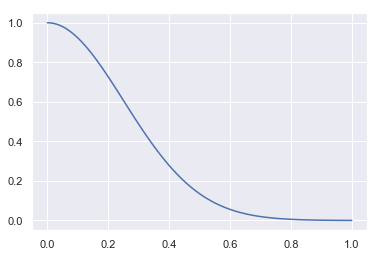

In [141]:
def rbf(X, x, var, l):
      return var*np.exp(-(abs(X-x)*abs(X-x))/(2*math.pow(l, 2)))

xmin = 0
xmax = 1
xx = np.linspace(xmin, xmax, 100)[:,None]
sns.lineplot(x=xx[:,0], y = rbf(xx, 0, 1, 0.25)[:,0])

Having concluded a value of $l$ that makes sense, we now put a distribution over it with mean around the chosen value and a variance representing our certainty. I am not too certain in my belief, and believe that $l$ could take on values quite a bit bigger than the mean value. Since the length scale is strictly positive I've chosen a gamma distribution, which it can be seen in the plot below. This is our length scale prior!

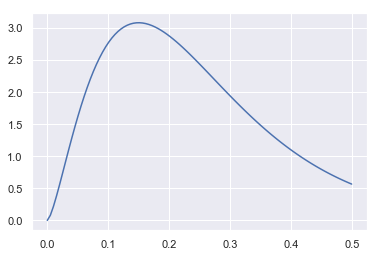

In [142]:
xmin = 0
xmax = 0.5
l_alpha = 2.5
l_theta = 0.1
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=l_alpha, scale=l_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Kernel Variance ($\sigma_f$)
The kernel variance determines the average distance that the function output has from the function mean. Since the output of the function is on $[0, 1]$, the output should not need to vary more than this. To prevent overfitting a $\sigma_f = 0.6$ seems right, but let's go with quite high uncertainty on this one. Since it is also a strictly positive quantity a gamma distribution is used here as well, like with the lengthscale.

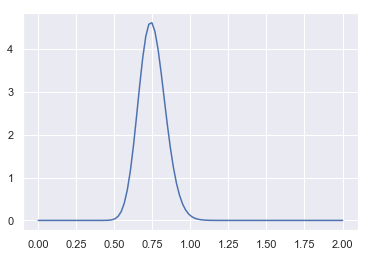

In [143]:
xmin = 0
xmax = 2
sigmaf_alpha = 75
sigmaf_theta = 0.01
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigmaf_alpha, scale=sigmaf_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

### Likelihood Variance ($\sigma$)
We also need to chose a prior for the likelihood variance $\sigma$, which representas the measurement noise. This model will assume a static variance, even though we know that it depends on where in the city you are. In mode dense areas the GPS accuracy suffers a bit while it works well in more rural areas. A seperate model for the GPS variance estimation should be used if this was done properly.

In the provided thesis the average GPS variance of a smartphone is claimed to be $\sigma = 10^-5$ so we'll go with that, but like with $\sigma_f$ we will be quite uncertain.

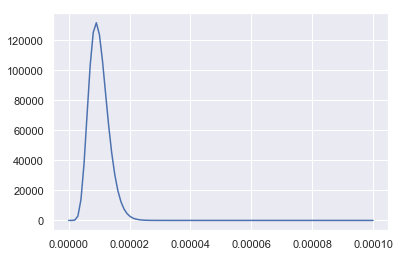

In [144]:
xmin = 0
xmax = 0.0001
sigma_alpha = 10
sigma_theta = 0.000001
xx = np.linspace(xmin, xmax, 100)[:,None]
y = stats.gamma.pdf(xx, a=sigma_alpha, scale=sigma_theta)
sns.lineplot(x = xx[:,0], y = y[:,0])

In [145]:
d_lat = train.lat.max() - train.lat.min()
d_lon = train.lon.max() - train.lon.min()
print(d_lat, d_lon)

0.0472011566161985 0.009494781494097992


## Mean time_left
Started to figure out mean time_left trajectory for each segment

In [177]:
print(train.traj.unique())

segments = {}

curr_seg = 0
for x in train.itertuples():
    if x.seg != curr_seg:
        #print(x)
        
        tup = (x.time_left, x.traj)
        
        if x.seg in segments:
            segments[x.seg].append(tup)
        else:
            segments[x.seg] = [tup]
        
        curr_seg = x.seg
        
#print(segments)
        
for s, traj_list in segments.items():
    traj_list.sort()
    print(traj_list)

[   6   35  109  129  134  179  185  189  208  294  305  336  393  411
  511  595  597  652  716  720  723  770  771  806  829  882  931  943
  964  971 1005 1054 1057 1067 1068 1097 1107 1108 1112 1114 1121 1160
 1169 1227 1246 1271 1289 1319 1330 1387 1392 1422 1552 1622 1639 1674
 1688 1739 1755 1829 1876 1907 2014 2045 2097 2139 2182 2194 2211 2234
 2271 2306 2319 2330 2414 2513 2609 2611 2627 2675 2763 2768 2776 2780
 2802 2804 2810 2814 2858 2912 2966 3014 3028 3088 3109 3127 3159 3214
 3264 3384 3404 3420 3449 3459 3463 3496 3499 3544 3610 3618 3632 3654
 3655]
[(25.0, 971), (26.0, 597), (27.0, 595), (31.0, 294), (31.0, 1160), (32.0, 185), (37.0, 770), (37.0, 1121), (39.0, 2211), (41.0, 3655), (42.0, 3499), (43.0, 1387), (44.0, 2234), (44.0, 3088), (45.0, 511), (45.0, 716), (45.0, 1097), (45.0, 2858), (46.0, 720), (46.0, 723), (46.0, 1829), (46.0, 1907), (47.0, 1319), (47.0, 1422), (48.0, 109), (48.0, 393), (48.0, 2306), (48.0, 2611), (49.0, 305), (49.0, 829), (49.0, 1107), (49.

In [179]:
train[train.traj == 2814]

,lat,lon,traj,seg,speed,time_left,progress
75919,15.565068,58.414597,2814,2,5.60,3674.0,0.000000
75920,15.564950,58.414550,2814,2,4.62,62.0,0.025000
75921,15.564624,58.414387,2814,2,-1.00,3649.0,0.050000
75922,15.564917,58.414536,2814,2,2.82,47.0,0.075000
75923,15.564827,58.414486,2814,2,3.65,3644.0,0.100000
75924,15.564774,58.414459,2814,2,4.01,3643.0,0.125000
75925,15.564713,58.414433,2814,2,4.47,3642.0,0.150000
75926,15.564624,58.414387,2814,2,6.17,42.0,0.175000
75927,15.564528,58.414352,2814,2,6.73,3640.0,0.200000
75928,15.564429,58.414307,2814,2,7.25,3639.0,0.225000


In [154]:
from math import radians, cos, sin, asin, sqrt, isnan

def haversine(lon1, lat1, lon2, lat2):
    """
   Calculate the great circle distance between two points
   on the earth (specified in decimal degrees)
   """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 # Radius of earth in kilometers
    return c * r

def calculate_l(data, c):
    N = len(data)

    dy = haversine(np.min(data.lon), 0, np.max(data.lon), 0)
    dx = haversine(0, np.min(data.lat), 0, np.max(data.lat))
    maxd = np.max([dx, dy])

    l = (maxd/N)*c
    var = 0.1
    
    return l, var

# Training
Alrighty, time to train a GP. The idea here is to train on a single trajectory that embodies what we want from the synchronisation. This works because the model is used to interpolation and has consequently no need to generalise. We use both the training and support data for this model, for reasons mentioned in notebook 1.

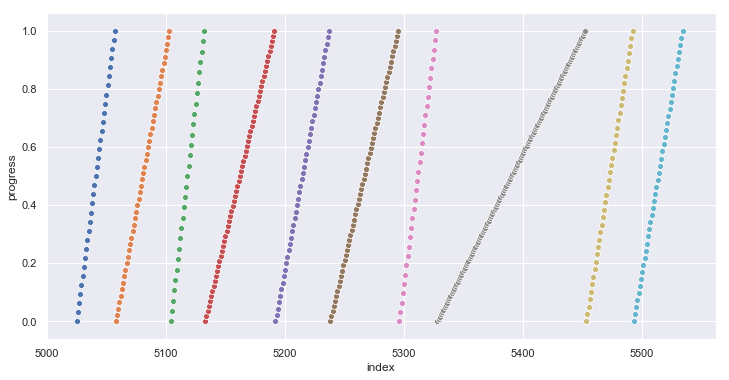

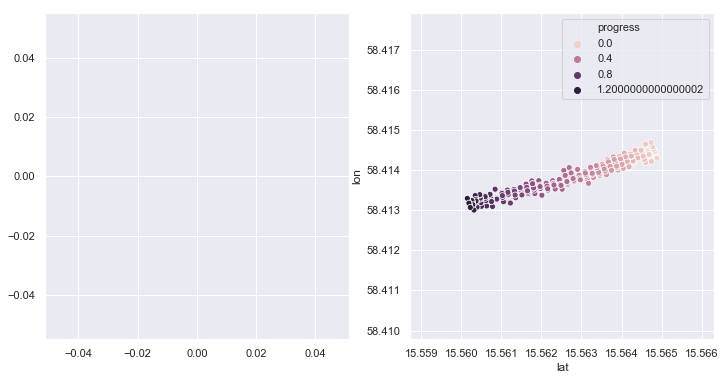

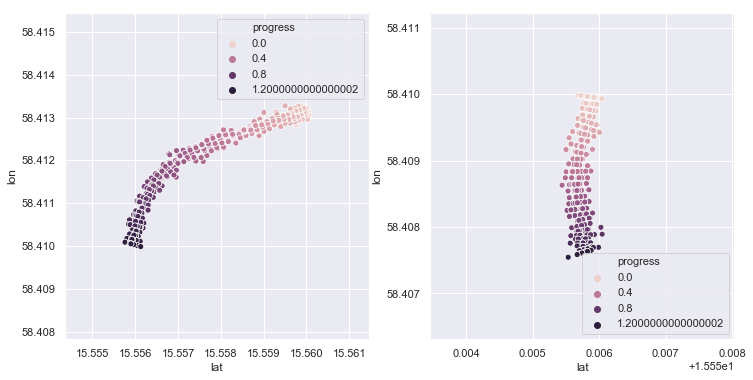

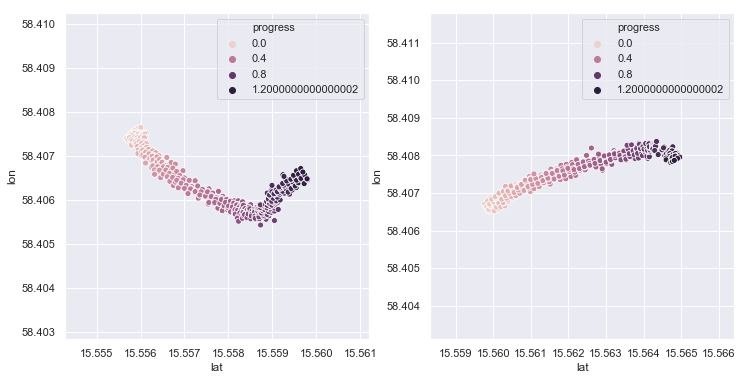

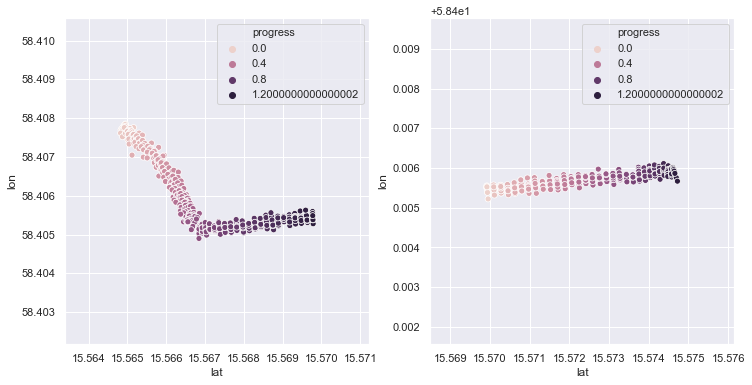

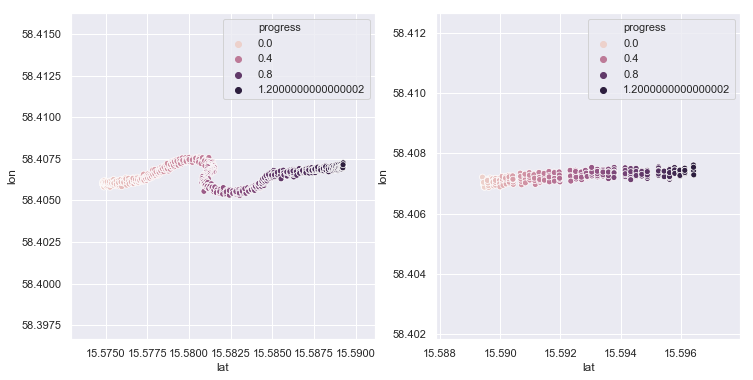

In [155]:
n_trajs = train.traj.unique()
traj_n = n_trajs[2]
traj_n = 185
traj = train[train.traj == traj_n]
traj_support = support[support.traj == traj_n]
train_traj = traj.append(traj_support)
plot.traj_progress(traj)
plot.traj_segment_grid(train_traj, 'lat', 'lon', hue='progress')

Having found a seg_n that seems typical we can now fit GPs for each of its segments.

In [162]:
def train_gp(data, route_n, traj_n, seg_n):
    seg = data[data.seg == seg_n]
    d_lat = train.lat.max() - train.lat.min()
    d_lon = train.lon.max() - train.lon.min()
    X = seg[['lat', 'lon']].values
    Y = seg[['progress']]
    model = gp.build_synch(X, Y, route_n, seg_n)
    
    l_mean, l_var = calculate_l(seg, 300)
    print("THEM PRIORS", l_mean, l_var)
    model.model.kern.lengthscale.set_prior(GPy.priors.Gamma.from_EV(l_mean, l_var))
    #model.model.kern.variance.set_prior(GPy.priors.Gamma.from_EV(0.5, 0.2))
    #model.model.likelihood.variance.set_prior(GPy.priors.Gamma.from_EV(0.005, 0.00001))
    model.model.likelihood.variance = 0.0003
    model.model.likelihood.variance.fix()
    gp.train(model, n_restarts=5)
    print(model.model)
    return model

np.random.seed(2)
n_segs = traj.seg.unique()
gps = {seg_n: train_gp(train_traj, route_n, traj_n, seg_n) for seg_n in n_segs}

reconstraining parameters GP_regression.rbf.lengthscale


THEM PRIORS 0.43530840016927297 0.1
Optimization restart 1/5, f = -1052.3173157049332
Optimization restart 2/5, f = -1052.317315705106
Optimization restart 3/5, f = -1052.317315704999
Optimization restart 4/5, f = -1052.3173157033305


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -1052.3173157047613

Name : GP regression
Objective : -1052.317315705106
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |     priors   
  rbf.variance             |   3.879117229296182  |      +ve      |              
  rbf.lengthscale          |  1.8625837984958433  |      +ve      |  Ga(1.9, 4.4)
  Gaussian_noise.variance  |              0.0003  |   +ve fixed   |              
THEM PRIORS 0.2832139287686265 0.1
Optimization restart 1/5, f = -356.2390693474693
Optimization restart 2/5, f = -356.23906934849316
Optimization restart 3/5, f = -356.2390693489548
Optimization restart 4/5, f = -356.23906934905955


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -356.2390693387513

Name : GP regression
Objective : -356.23906934905955
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |     priors   
  rbf.variance             |   0.4942779643382786  |      +ve      |              
  rbf.lengthscale          |  0.23220634855221617  |      +ve      |  Ga(0.8, 2.8)
  Gaussian_noise.variance  |               0.0003  |   +ve fixed   |              
THEM PRIORS 0.25506556130489555 0.1
Optimization restart 1/5, f = -810.890857331246
Optimization restart 2/5, f = -810.8908573292031
Optimization restart 3/5, f = -810.8908573307804
Optimization restart 4/5, f = -810.8908573301808


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -810.8908570698133

Name : GP regression
Objective : -810.890857331246
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |     priors    
  rbf.variance             |   8.178385321497768  |      +ve      |               
  rbf.lengthscale          |  1.9259298069782682  |      +ve      |  Ga(0.65, 2.6)
  Gaussian_noise.variance  |              0.0003  |   +ve fixed   |               
THEM PRIORS 0.21230989694931562 0.1
Optimization restart 1/5, f = -1237.416456799187
Optimization restart 2/5, f = -1237.4164567977778
Optimization restart 3/5, f = -1237.416456798651
Optimization restart 4/5, f = -1237.4164567986059


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -1237.4164567984312

Name : GP regression
Objective : -1237.416456799187
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |     priors    
  rbf.variance             |    0.631709120120141  |      +ve      |               
  rbf.lengthscale          |  0.32811563704249314  |      +ve      |  Ga(0.45, 2.1)
  Gaussian_noise.variance  |               0.0003  |   +ve fixed   |               
THEM PRIORS 0.342065146355376 0.1
Optimization restart 1/5, f = -1047.002345132479
Optimization restart 2/5, f = -1047.002345134813
Optimization restart 3/5, f = -1047.0023451348243
Optimization restart 4/5, f = -1047.0023451275356


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -1047.0023451352713

Name : GP regression
Objective : -1047.0023451352713
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |     priors   
  rbf.variance             |  0.5666071614024588  |      +ve      |              
  rbf.lengthscale          |   0.539423720177664  |      +ve      |  Ga(1.2, 3.4)
  Gaussian_noise.variance  |              0.0003  |   +ve fixed   |              
THEM PRIORS 0.25946048756572415 0.1
Optimization restart 1/5, f = -1320.1876999215367
Optimization restart 2/5, f = -1320.1876999204558
Optimization restart 3/5, f = -1320.1876999215174
Optimization restart 4/5, f = -1320.1876999219123


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -1320.1876999221402

Name : GP regression
Objective : -1320.1876999221402
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |     priors    
  rbf.variance             |  0.6568942991426039  |      +ve      |               
  rbf.lengthscale          |  0.6482644569693407  |      +ve      |  Ga(0.67, 2.6)
  Gaussian_noise.variance  |              0.0003  |   +ve fixed   |               
THEM PRIORS 0.45495439403197446 0.1
Optimization restart 1/5, f = -325.29020287437453
Optimization restart 2/5, f = -325.29020286100183
Optimization restart 3/5, f = -325.290202871579
Optimization restart 4/5, f = -325.2902028722074
Optimization restart 5/5, f = -325.2902028737961

Name : GP regression
Objective : -325.29020287437453
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value

reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 1/5, f = -3752.3646241824185
Optimization restart 2/5, f = -3752.364624158938
Optimization restart 3/5, f = -3752.3646241795873
Optimization restart 4/5, f = -3752.3646241825063
Optimization restart 5/5, f = -3752.364624180177


reconstraining parameters GP_regression.rbf.lengthscale



Name : GP regression
Objective : -3752.3646241825063
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |     priors   
  rbf.variance             |   0.576720829626271  |      +ve      |              
  rbf.lengthscale          |  0.4972926111881644  |      +ve      |  Ga(1.2, 3.5)
  Gaussian_noise.variance  |              0.0003  |   +ve fixed   |              
THEM PRIORS 0.5311837510538393 0.1
Optimization restart 1/5, f = -761.3635372198574
Optimization restart 2/5, f = -761.3635372198215
Optimization restart 3/5, f = -761.3635372198041
Optimization restart 4/5, f = -761.3635372194362


reconstraining parameters GP_regression.rbf.lengthscale


Optimization restart 5/5, f = -761.3635372198859

Name : GP regression
Objective : -761.3635372198859
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |     priors   
  rbf.variance             |  0.4543739767340091  |      +ve      |              
  rbf.lengthscale          |  0.5045929252719026  |      +ve      |  Ga(2.8, 5.3)
  Gaussian_noise.variance  |              0.0003  |   +ve fixed   |              
THEM PRIORS 0.45308354757862024 0.1
Optimization restart 1/5, f = -1298.0237207034272
Optimization restart 2/5, f = -1298.0237207034277
Optimization restart 3/5, f = -1298.0237207022926
Optimization restart 4/5, f = -1298.023720703309
Optimization restart 5/5, f = -1298.0237207033852

Name : GP regression
Objective : -1298.0237207034277
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |               value  |

Below is a plot of the GPs and the synchronisation of some unseen new trajectories to test its robustness. We see that the synchronisation is quite robust, and so we save the trajectories. There is still improvements to be made but it's hard to figure out how it can be made better.

 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /usr/local/anaconda3/lib/python3.6/site-packages/matplotl

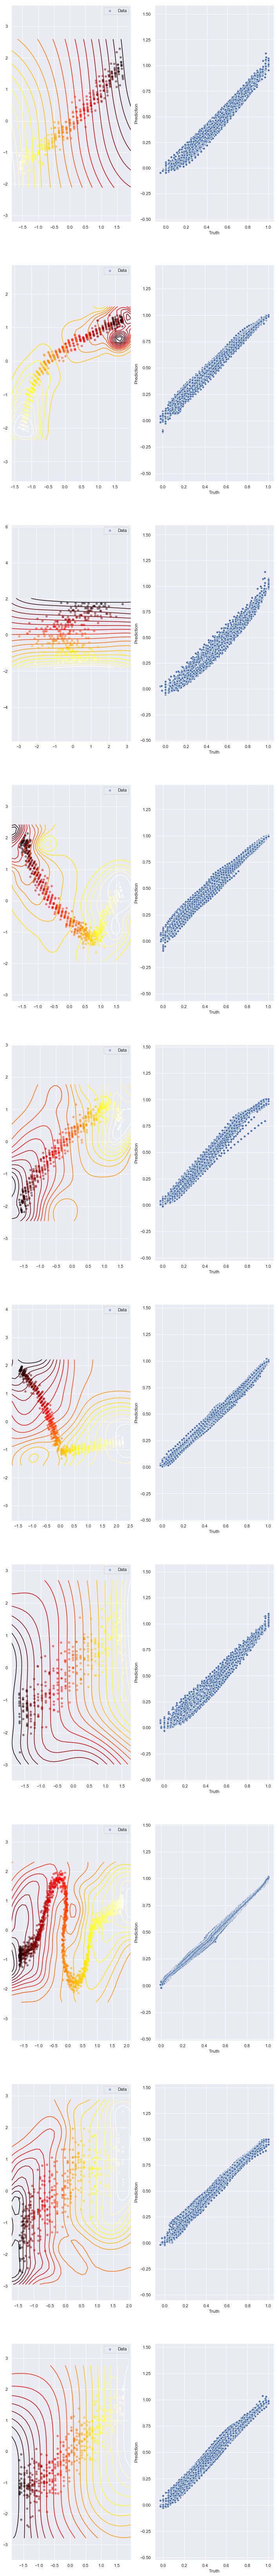

In [163]:
def synch_data(synch_gp, data):
    latlon = ['lat', 'lon']
    X = data[latlon].values
    tau, _var = gp.predict(synch_gp, X)
    synched_data = data.copy()
    synched_data['tau'] = tau
    synched_data.drop(xy, axis=1)
    return synched_data

test = pd.read_pickle('test.pkl')
_fig, axs = plt.subplots(nrows=len(n_segs), ncols=2, figsize=(12, int(12*len(n_segs))))
for i, seg_n, model in zip(range(len(n_segs)), n_segs, gps.values()):
    seg = test[test.seg == seg_n]
    X = seg[['lat', 'lon']].values
    tau, _var = gp.predict(gps[int(seg_n)], X)
    df = pd.DataFrame({'Prediction': tau.T[0], 'Truth': seg.progress})
    model.model.plot(ax=axs[i, 0])
    axs[i, 0].set_aspect('equal', 'datalim')
    sns.scatterplot(data=df, x='Truth', y='Prediction', ax=axs[i, 1])
    axs[i, 1].set_aspect('equal', 'datalim')

In [160]:
for model in gps.values():
     gp.save(model)

A final test of the load functions and plotting of (training) predictions

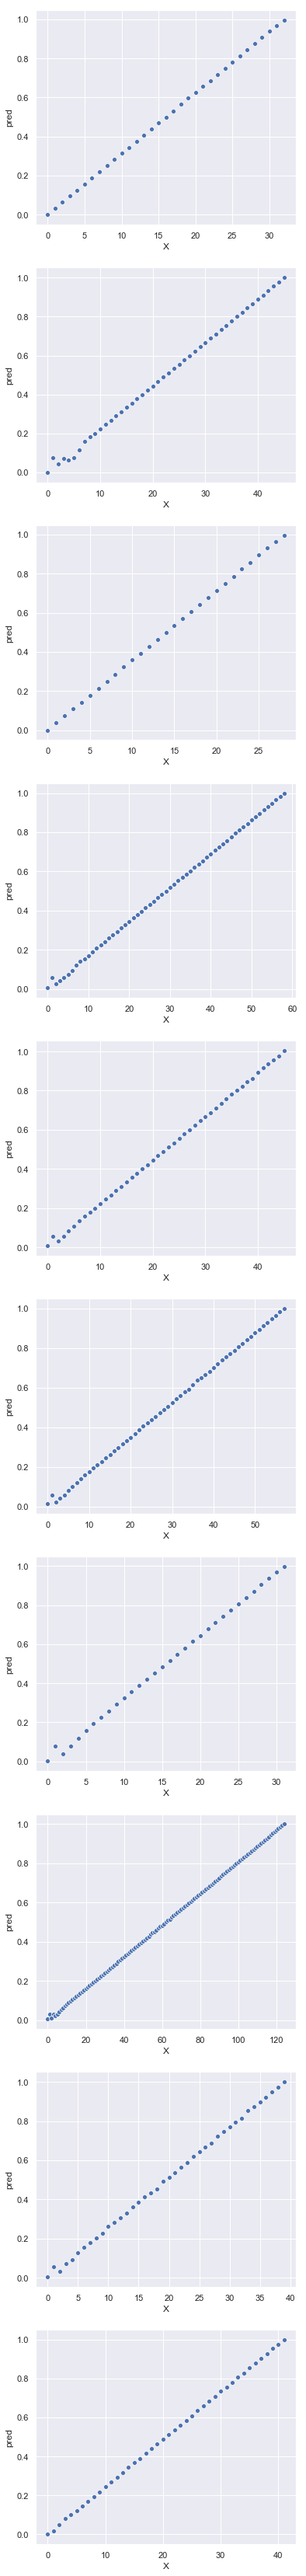

In [161]:
traj = train[train.traj == traj_n]
_fig, ax = plt.subplots(nrows=len(n_segs), ncols=1, figsize=(6, int(6*len(n_segs))))
for i, seg_n in zip(range(len(n_segs)), n_segs):
    seg = traj[traj.seg == seg_n]
    sgp = gp.load_synch(route_n, seg_n)
    X = seg[['lat', 'lon']].values
    mean, _var = gp.predict(sgp, X)
    df = pd.DataFrame({'pred': mean.T[0], 'X': range(X.shape[0])})
    sns.scatterplot(data=df, x='X', y='pred', ax=ax[i])